## RFM(Recency, Frequency, Monetary)

* RFM은 가치있는 고객을 추출해내어 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서도 유용하게 사용될 수 있는 방법으로 알려져 있어 마케팅에서 가장 많이 사용되고 있는 분석방법 중 하나이다. RFM은 구매 가능성이 높은 고객을 선정하기 위한 데이터 분석방법으로서, 분석과정을 통해 데이터는 의미있는 정보로 전환된다.

* RFM은 Recency, Frequency, Monetary의 약자로 고객의 가치를 다음의 세 가지 기준에 의해 계산하고 있다.

* Recency - 거래의 최근성: 고객이 얼마나 최근에 구입했는가?
* Frequency - 거래빈도: 고객이 얼마나 빈번하게 우리 상품을 구입했나?
* Monetary - 거래규모: 고객이 구입했던 총 금액은 어느 정도인가?

### RFM 모형

* Scoring 기법: RFM의 요인을 각각 5등급으로 등간격으로 분류하는 방법이다.
* 현재 개발된 RFM 모형은 크게 4가지로 분류 할 수 있다. 이 문서의 내용들은 정설이 아니며 신뢰하기 어려움을 전제로 참고해야한다.
    * 모델1. RFM 각 요소의 20% rule의 적용
    * 모델2. 비율 척도에 의한 양적인 정도의 차이에 따른 등간격의 5등급 분류
    * 모델3. 상하 20%를 제외한 등간격 척도에 의한 그룹 분류
    * 모델4. 군집 분석에 의한 각 요소 별 5개의 그룹 분류
* Data Mining 기법을 이용한 모형
* 회귀분석
* 선형 회귀 분석을 이용한 모형: 고객의 구매 최근성, 구매 빈도, 구매 금액 등 고객의 수익 기여도를 나타내는 세가지 지표들의 선형결합으로 세가지 지표들을 점수화 한다.
* 다중 회귀 분석을 이용한 모형: 각 고객의 구매 행동을 나타내는 R,F,M의 변수들을 독립변수로하고 고객의 미래 구매 행동을 예측하는 기법.
* 신경망을 적용한 모형: 로지스틱 회귀 모형을 보완하는 차원에서 연구.
* 확률적 RFM모형:Colombo와 Weina의 확률적인 RFM모형은 과거의 고객의 응답 이력으로 고객의 미래 응답을 예측하는 행동모델이다.

출처 : [RFM - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/RFM)

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

## 폰트설정

In [2]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야합니다.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨집니다.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

## 데이터 로드

In [3]:
# raw = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")
# raw = pd.read_excel("data/Online Retail.xlsx", engine="openpyxl")
raw = pd.read_csv("data/online_retail.csv")
raw.shape

(541909, 8)

In [4]:
raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 유효 데이터만 추출

In [5]:
# "CustomerID" 가 있고 "Quantity" 가 0보다 큰 데이터를 가져옵니다.
# 구매하고 취소한 건 중 취소한 건만 제외하고 구매 건은 남깁니다.
df = raw[raw["CustomerID"].notnull() & (raw["Quantity"] > 0)].copy()
df.shape

(397924, 8)

## 구매 금액 계산

In [6]:
df["TotalPrice"] = df["UnitPrice"] * df["Quantity"]

## RFM 계산
### 전체 주문에서 최근 주문일 구하기

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [8]:
# Recency 계산을 위해 해당 주문에서 가장 최근 구매가 일어난 시간을 가져옴
last_timestamp = df['InvoiceDate'].max() + dt.timedelta(days = 1)
last_timestamp

Timestamp('2011-12-10 12:50:00')

### 고객별 Recency, Frequency, Monetary 값 구하기

In [9]:
# Recency : 최근 날짜 기준으로 마지막으로 구매한 날짜와 얼마나 차이가 나는지
# Frequency : 구매 빈도수
# Monetary : 총 구매 금액
rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (last_timestamp - x.max()).days,
                                      'InvoiceNo':'count',
                                      'TotalPrice': 'sum'})

In [10]:
# InvoiceDate 는 Recency
# InvoiceNo 는 Frequency
# TotalPrice 는 MonetaryValue
rfm.rename(columns={'InvoiceDate':'Recency', 
                    'InvoiceNo':'Frequency', 
                    'TotalPrice':'MonetaryValue'},
           inplace= True)
rfm

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


In [11]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4339.000000,4339.000000,4339.000000
mean,92.518322,91.708689,2053.793018
std,100.009747,228.792852,8988.248381
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,307.245000
50%,51.000000,41.000000,674.450000
75%,142.000000,100.000000,1661.640000
max,374.000000,7847.000000,280206.020000


## RFM 모형

* Scoring 기법: RFM의 요인을 각각 5등급으로 등간격으로 분류하는 방법이다.
* 현재 개발된 RFM 모형은 크게 4가지로 분류 할 수 있다. 이 문서의 내용들은 정설이 아니며 신뢰하기 어려움을 전제로 참고해야한다.
    * 모델1. RFM 각 요소의 20% rule의 적용
    * 모델2. 비율 척도에 의한 양적인 정도의 차이에 따른 등간격의 5등급 분류
    * 모델3. 상하 20%를 제외한 등간격 척도에 의한 그룹 분류
    * 모델4. 군집 분석에 의한 각 요소 별 5개의 그룹 분류
    
출처 : [RFM - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/RFM)

### qcut을 통한 RFM 변수 만들기

In [12]:
# Recency 는 최근일수록 높은 스코어를 갖도록 합니다.
# Frequency, MonetaryValue 는 값이 클 수록 높은 스코어를 갖도록 합니다.
r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)
cut_size= 5

In [13]:
r_cut = pd.qcut(rfm['Recency'], q=cut_size, labels = r_labels)
f_cut = pd.qcut(rfm['Frequency'], q=cut_size, labels = f_labels)
m_cut = pd.qcut(rfm['MonetaryValue'], q=cut_size, labels = m_labels)
# assign 을 사용하면 여러 변수를 한 번에 만들 수 있습니다.
rfm = rfm.assign(R=r_cut, F=f_cut, M=m_cut)

In [14]:
rfm

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,2,182,4310.00,5,5,5
12348.0,75,31,1797.24,2,3,4
12349.0,19,73,1757.55,4,4,4
12350.0,310,17,334.40,1,2,2
...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1
18281.0,181,7,80.82,1,1,1
18282.0,8,12,178.05,5,1,1


### RFM Segment

In [15]:
# RFM_segment 값을 구합니다. 
# R, F, M 값을 문자 그대로 붙여서 세그먼트를 구분합니다.
rfm["RFM_segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

### RFM Score

In [16]:
# R, F, M 값의 합계를 구해서 세그먼트 점수를 구합니다.
rfm["RFM_score"] = rfm[["R", "F", "M"]].astype(int).sum(axis=1)
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7
12347.0,2,182,4310.00,5,5,5,555,15
12348.0,75,31,1797.24,2,3,4,234,9
12349.0,19,73,1757.55,4,4,4,444,12
12350.0,310,17,334.40,1,2,2,122,5
...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3
18281.0,181,7,80.82,1,1,1,111,3
18282.0,8,12,178.05,5,1,1,511,7


In [42]:
score_rfm = rfm.groupby(["RFM_score"]).agg({"Recency" : "mean", 
                                "Frequency" : "mean", 
                                "MonetaryValue" : ["mean", "sum"]})
score_rfm.style.background_gradient().format("{:,.0f}")

### qcut을 통한 고객군 나누기

In [17]:
# qcut 을 통해 3단계로 "silver", "gold", "platinum" 고객군을 나눕니다. 
rfm["RFM_class"] = pd.qcut(rfm["RFM_score"], 3, labels=["silver", "gold", "platinum"])
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,silver
12347.0,2,182,4310.00,5,5,5,555,15,platinum
12348.0,75,31,1797.24,2,3,4,234,9,gold
12349.0,19,73,1757.55,4,4,4,444,12,platinum
12350.0,310,17,334.40,1,2,2,122,5,silver


In [18]:
# "RFM_class" 별로 그룹화 하고 "RFM_score" 의 describe 값을 구합니다.
rfm.groupby(["RFM_class"])["RFM_score"].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,1667.0,5.212358,1.385663,3.0,4.0,5.0,6.0,7.0
gold,1405.0,9.456940,1.113452,8.0,8.0,9.0,10.0,11.0
platinum,1267.0,13.456985,1.126447,12.0,12.0,13.0,14.0,15.0


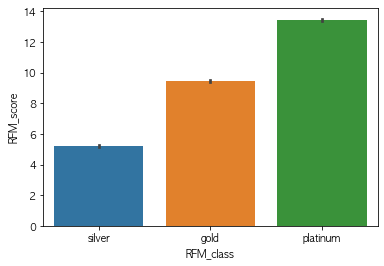

In [19]:
# RFM_class 별 평균 RFM_score
sns.barplot(data=rfm, x="RFM_class", y="RFM_score")

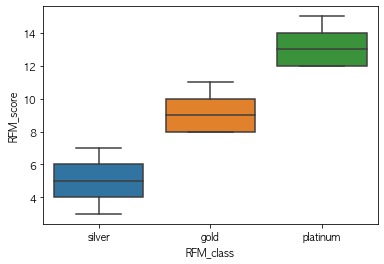

In [20]:
sns.boxplot(data=rfm, x="RFM_class", y="RFM_score")

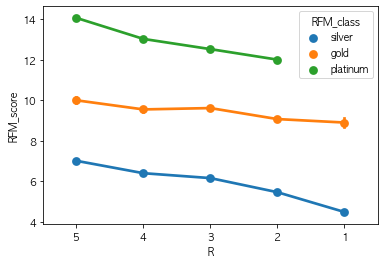

In [21]:
sns.pointplot(data=rfm, x="R", y="RFM_score", hue="RFM_class")

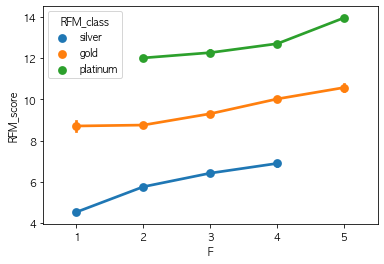

In [22]:
sns.pointplot(data=rfm, x="F", y="RFM_score", hue="RFM_class")

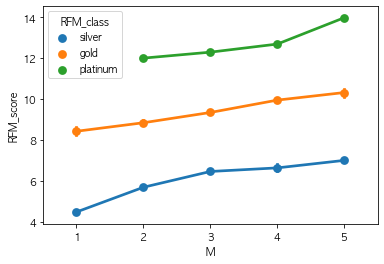

In [23]:
sns.pointplot(data=rfm, x="M", y="RFM_score", hue="RFM_class")

In [24]:
# "RFM_class" 별로 그룹화 하고 "Recency", "Frequency" 의 평균을 
# "MonetaryValue"의 "mean", "sum", "count" 값을 구합니다.
rfm_agg = rfm.groupby(["RFM_class"]).agg({"Recency": "mean", 
                                "Frequency": "mean", 
                                "MonetaryValue" : ["mean", "sum", "count"]})
rfm_agg

Recency   Frequency MonetaryValue                   
                 mean        mean          mean          sum count
RFM_class                                                         
silver     169.956209   17.197361    412.876612   688265.312  1667
gold        66.089680   56.272598   1127.709895  1584432.402  1405
platinum    19.940016  229.039463   5239.708122  6638710.190  1267

In [25]:
# 위에서 구한 값을 .style.background_gradient() 로 봅니다.
rfm_agg.astype(int).style.background_gradient().format("{:,}")

In [26]:
#.style.format("{:,}") 로 천단위 ,를 출력해 봅니다.
rfm_agg.astype(int).style.format("{:,}")

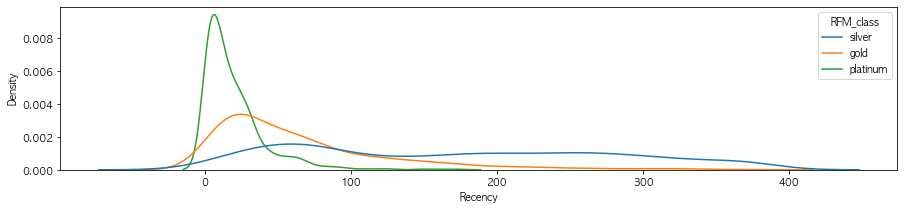

In [27]:
# kdeplot으로 Recency 의 RFM_class 별 분포를 그립니다.
plt.figure(figsize=(15, 3))
sns.kdeplot(data=rfm, x="Recency", hue="RFM_class")

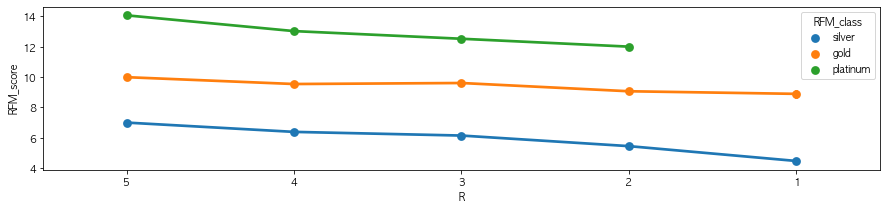

In [28]:
# pointplot 으로 Recency 의 RFM_class 별 분포를 그립니다.
plt.figure(figsize=(15, 3))
sns.pointplot(data=rfm, x="R", y="RFM_score", hue="RFM_class")

In [29]:
# 두 개의 그래프를 그리는 함수를 만듭니다.
def show_kde_point_plot(kde_x="Recency", point_x="R"):
    plt.figure(figsize=(15, 3))
    sns.kdeplot(data=rfm, x=kde_x, hue="RFM_class")
    plt.figure(figsize=(15, 3))
    sns.pointplot(data=rfm, x=point_x, y="RFM_score", hue="RFM_class")

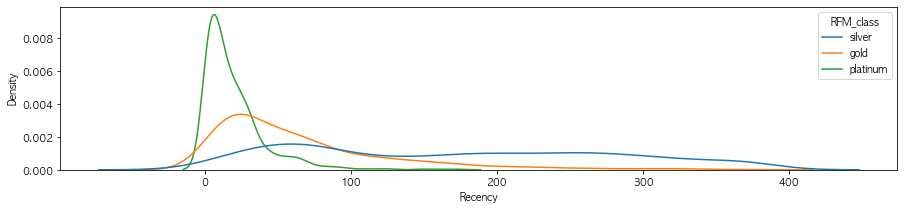

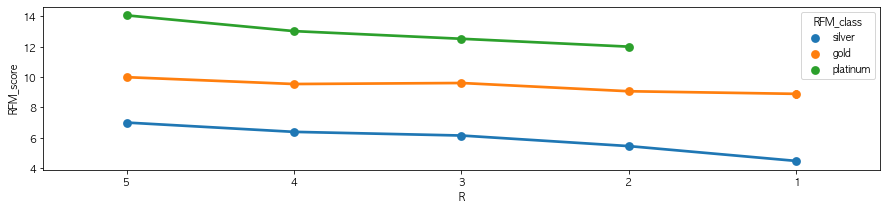

In [30]:
show_kde_point_plot(kde_x="Recency", point_x="R")

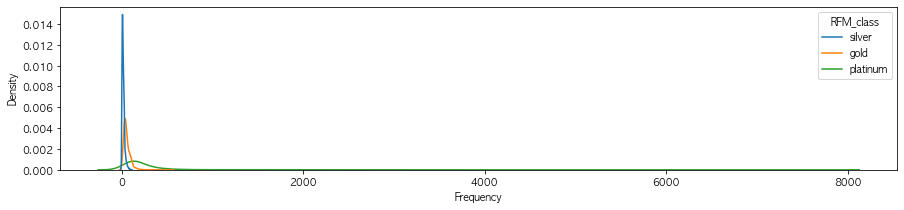

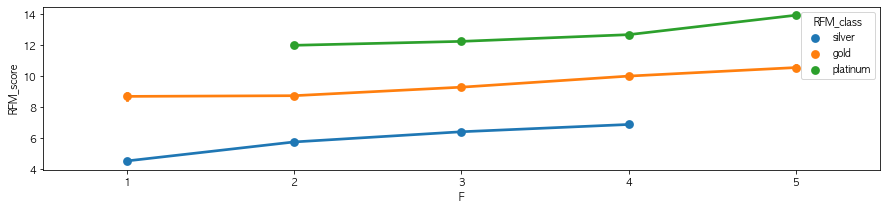

In [31]:
show_kde_point_plot(kde_x="Frequency", point_x="F")

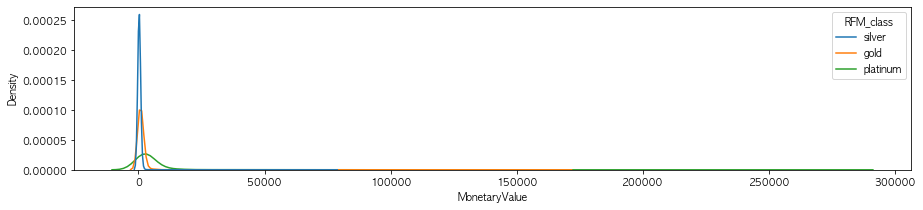

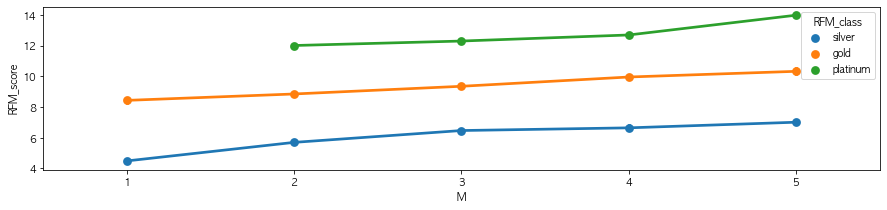

In [32]:
show_kde_point_plot(kde_x="MonetaryValue", point_x="M")

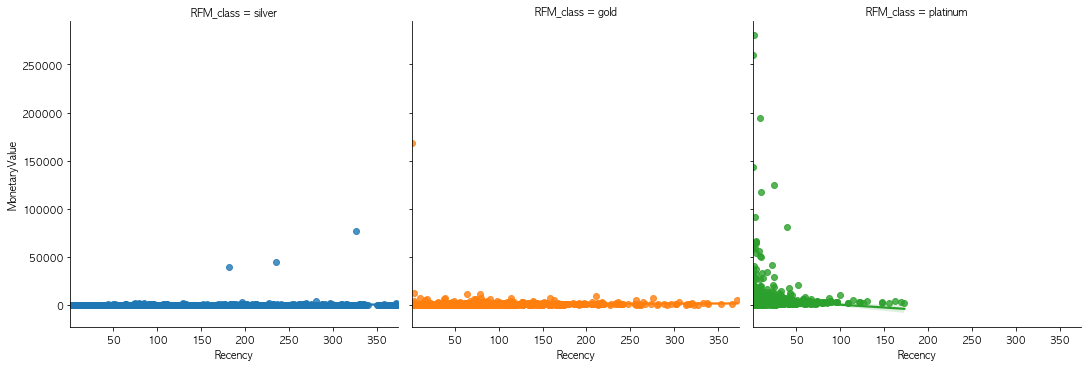

In [33]:
# lmplot 을 통해  x="Recency", y="MonetaryValue", hue="RFM_class", col="RFM_class" 값을 시각화 합니다.
sns.lmplot(data=rfm, x="Recency", y="MonetaryValue", hue="RFM_class", col="RFM_class")

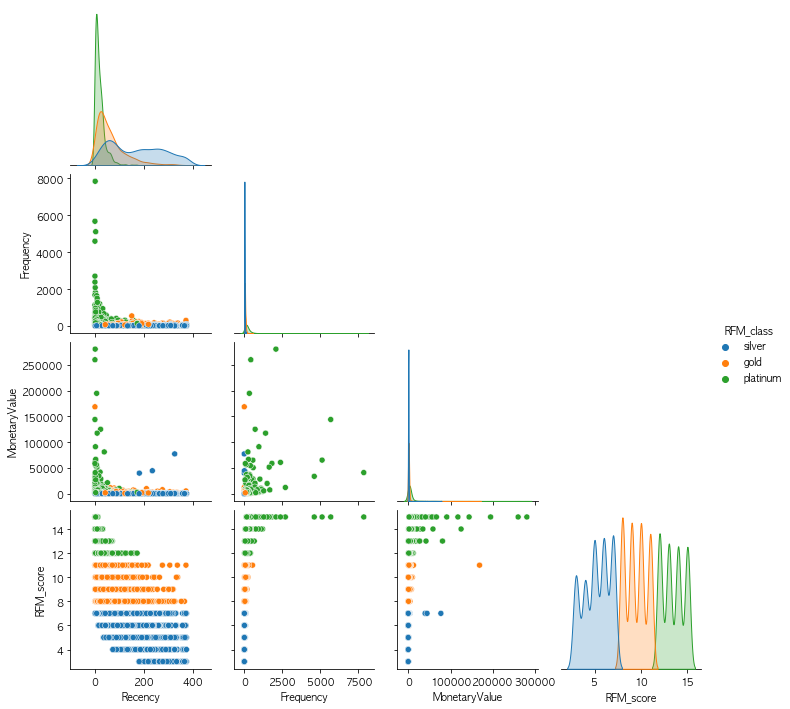

In [34]:
# pairplot 을 통해 "RFM_class" 별로 분포를 시각화 합니다.
sns.pairplot(data=rfm, hue="RFM_class", corner=True)